In [263]:
import numpy as np
import pandas as pd
import hashlib
from sklearn.linear_model import Lasso
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt
np.random.seed(42)

 ### Helper Functions

In [265]:
def bloom_hash(input_string, salt, num_bits):
    key = (input_string + "_" + salt).encode('utf-8')
    hash_digest = hashlib.sha256(key).digest()
    hash_val = int.from_bytes(hash_digest[:4], 'big')
    return hash_val % num_bits

def pad_string(s, maxlen):
    s = s[:maxlen].ljust(maxlen)
    return s

def normalize_urls(urls):
    urls = [u.lower().replace("https://", "").replace("http://", "").rstrip("/") for u in urls]
    return urls

### Load Dataset

In [ ]:
data = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv', header=None)
urls = data.iloc[1:, 1].astype(str).values
labels = data.iloc[1:, -1].astype(int).values
N = min(1000, len(urls))
websites = urls[:N]
labels = labels[:N]

In [267]:
def run_pipeline(threshold=0.003, num_bloombits=2048, num_hashes=5, 
                 prob_p=0.5, prob_q=0.75, prob_f=0.5, num_views=15,
                 max_url_length=100, lambda_lasso=0.0001):# --- Step 1: PRR Encoding ---
    # --- Step 1: PRR Encoding ---
    prr_matrix = np.zeros((N, num_bloombits), dtype=int)
    for i in range(N):
        s = pad_string(websites[i], max_url_length)
        bf = np.zeros(num_bloombits, dtype=int)
        for h in range(1, num_hashes + 1):
            salt = f"{h}_cohort"
            idx = bloom_hash(s, salt, num_bloombits)
            bf[idx] = 1
        f_mask = np.random.rand(num_bloombits) < prob_f
        uniform = np.random.rand(num_bloombits) < 0.5
        prr = np.where(f_mask, uniform, bf)
        prr_matrix[i] = prr

    # --- Step 2: IRR Views ---
    irr_matrix = []
    for v in range(num_views):
        print(f"View {v+1}")
        for i in range(N):
            prr = prr_matrix[i]
            p_bits = np.random.rand(num_bloombits) < prob_p
            q_bits = np.random.rand(num_bloombits) < prob_q
            irr = np.where(prr == 1, q_bits, p_bits)
            irr_matrix.append(irr)
    irr_matrix = np.array(irr_matrix)

    # --- Step 3: Design Matrix for Candidates ---
    candidates = np.unique(websites)
    M = len(candidates)
    A = np.zeros((M, num_bloombits), dtype=int)
    for i, s in enumerate(candidates):
        s = pad_string(s, max_url_length)
        for h in range(1, num_hashes + 1):
            salt = f"{h}_cohort"
            idx = bloom_hash(s, salt, num_bloombits)
            A[i, idx] = 1

    # --- Step 4: Frequency Reconstruction ---
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline

    # Compute y as usual
    y = irr_matrix.mean(axis=0)

    # Compute alpha correctly
    n_samples = A.shape[0]
    alpha = lambda_lasso / n_samples

    # Setup Lasso pipeline with standardization
    model = make_pipeline(
        StandardScaler(),
        Lasso(
            alpha=alpha,
            fit_intercept=True,
            positive=False,
            tol=1e-4,
            max_iter=2000
        )
    )

    try:
        model.fit(A.T, y)
        # Extract Lasso from pipeline to get coefficients
        lasso_coef = model.named_steps['lasso'].coef_
        reconstructed_freq = np.maximum(lasso_coef, 0)
        nonzero = np.sum(reconstructed_freq > 0)
        print(f"Used LASSO: {nonzero} non-zero coefficients")
        if nonzero == 0:
            raise Exception("Fallback to lsqnonneg")
    except:
        res = lsq_linear(A.T, y, bounds=(0, np.inf))
        reconstructed_freq = res.x
        print(f"Used lsqnonneg: {np.sum(reconstructed_freq > 0)} non-zero coefficients")


    # --- Step 5: Detection with Normalized Matching --
    detected = np.where(reconstructed_freq > threshold)[0]
    recon_websites = candidates[detected]

    recon_clean = normalize_urls(recon_websites)
    true_malicious = normalize_urls(websites[labels == 0])
    recon_labels = [1 if r in true_malicious else 0 for r in recon_clean]

    print("\nReconstructed Websites (label = 1 = phishing):")
    for i, r in enumerate(recon_websites):
        print(f"{r}\tlabel={recon_labels[i]}")

    # --- Metrics ---
    tp = sum(recon_labels)
    fp = len(recon_labels) - tp
    fn = sum([1 for url in true_malicious if url not in recon_clean])
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    print(f"\n# Detected: {len(recon_websites)}\n# True phishing: {len(true_malicious)}\n# Matched: {tp}")
    print(f"Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f}")

    
    return precision, recall, f1, recon_websites, reconstructed_freq[detected], recon_labels, true_malicious


### Threshold

In [268]:
thresholds = np.linspace(0.0000005, 0.0006, 20)
results = []
for th in thresholds:
    # Unpack only the first 3 (rest are ignored here)
    precision, recall, f1, _, reconstructed_freq, _, _ = run_pipeline(threshold=th)
    results.append((th, precision, recall, f1))

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 518 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://1636365.com/assets/@popperjs.36402333.js/assets/@ctrl.fd318bfa.js/assets/@ctrl.b082b0c1.js/assets/@vueuse.7ab573ac.js/	label=1
http://43.134.167.94/servicelogin?passive=1209600&amp;continue=https://accounts.google.com/?&amp;xrealip=107.178.232.242&amp;followup=https://accounts.google.com/?&amp;xrealip=107.178.232.242	label=1
http://app-parallel-fi.netlify.app	label=1
http://btconnect-8a0479.webflow.io/	label=1
http://chieuphan-bdshotram.com/webs/	label=1
http://cn52393.tw1.ru/ups/login/details.php	label=1
http://con2dapps.com	label=1
http://cpanel10wh.bkk1.cloud.z.com/~cp785288/hlep/login/billing.php?verify_account=session=nl&amp;c9af20c816b1cce4f06368be3327e297=&amp;dispatch=15464ad822e0af50d3b1df6196cac08a9e8edfbd	label=1
http://dfjhjhjb2.com/?fds21fds54fds54sd	label=1
http://forcedi

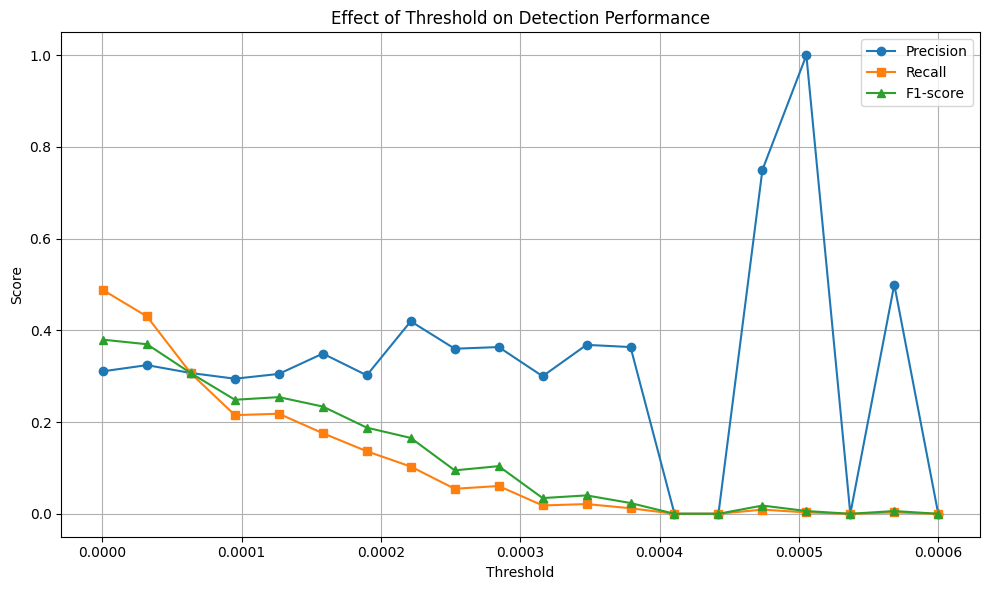

Detection Metrics per Threshold:


,Threshold,Precision,Recall,F1
0,0.0000,0.3108,0.4879,0.3797
1,0.0000,0.3242,0.4303,0.3698
2,0.0001,0.3070,0.3061,0.3065
3,0.0001,0.2946,0.2152,0.2487
4,0.0001,0.3051,0.2182,0.2544
5,0.0002,0.3494,0.1758,0.2339
6,0.0002,0.3020,0.1364,0.1879
7,0.0002,0.4198,0.1030,0.1655
8,0.0003,0.3600,0.0545,0.0947
9,0.0003,0.3636,0.0606,0.1039


In [269]:
df_results = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])
import seaborn as sns

# --- Plotting Metrics ---
plt.figure(figsize=(10, 6))
plt.plot(df_results["Threshold"], df_results["Precision"], label='Precision', marker='o')
plt.plot(df_results["Threshold"], df_results["Recall"], label='Recall', marker='s')
plt.plot(df_results["Threshold"], df_results["F1"], label='F1-score', marker='^')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Effect of Threshold on Detection Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Table: Display Full Results (One Row per Threshold) ---
from IPython.display import display

print("Detection Metrics per Threshold:")
display(df_results.round(4))  # Round for cleaner table display



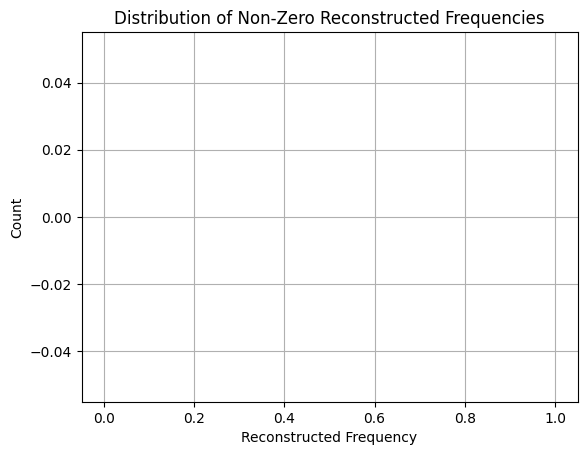

In [270]:
import matplotlib.pyplot as plt

plt.hist(reconstructed_freq[reconstructed_freq > 0], bins=100)
plt.xlabel("Reconstructed Frequency")
plt.ylabel("Count")
plt.title("Distribution of Non-Zero Reconstructed Frequencies")
plt.grid(True)
plt.show()


In [271]:
best_row = df_results.loc[df_results['F1'].idxmax()]
print("Best Threshold:", best_row['Threshold'])
print(f"Precision: {best_row['Precision']:.2f}, Recall: {best_row['Recall']:.2f}, F1: {best_row['F1']:.2f}")
best_threshold = best_row['Threshold']

Best Threshold: 5e-07
Precision: 0.31, Recall: 0.49, F1: 0.38


In [ ]:
# Step 2: Sweep over Bloom filter sizes
bloom_sizes = [256, 512, 768, 1024, 1536, 2048, 3072, 4096, 6144, 8192, 10240, 12288, 16384]
results_bloom = []

for size in bloom_sizes:
    print(f"\n--- Testing Bloom Size: {size} ---")
    
    precision, recall, f1, recon_websites, reconstructed_freq, recon_labels, true_malicious = run_pipeline(
        threshold=best_threshold,
        num_bloombits=size
    )
    
    detected_count = len(recon_websites)
    true_phishing_count = len(true_malicious)
    matched = sum(recon_labels)
    
    results_bloom.append((
        size, precision, recall, f1,
        detected_count, true_phishing_count, matched
    ))

# Step 3: Convert to DataFrame
df_bloom = pd.DataFrame(results_bloom, columns=[
    "Bloom Size", "Precision", "Recall", "F1",
    "Detected", "True Phishing", "Matched"
])

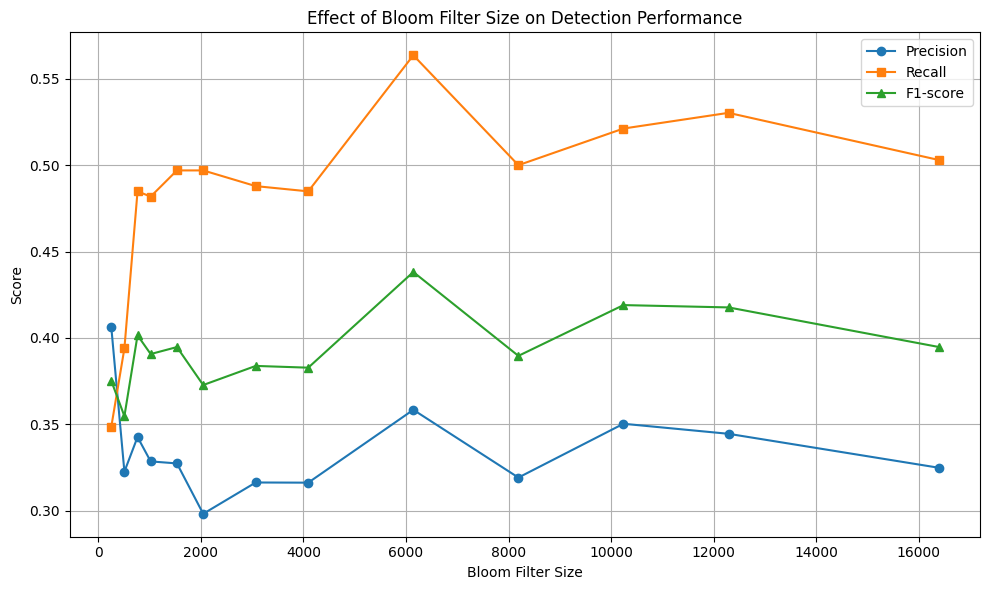

In [273]:
plt.figure(figsize=(10, 6))
plt.plot(df_bloom["Bloom Size"], df_bloom["Precision"], label='Precision', marker='o')
plt.plot(df_bloom["Bloom Size"], df_bloom["Recall"], label='Recall', marker='s')
plt.plot(df_bloom["Bloom Size"], df_bloom["F1"], label='F1-score', marker='^')
plt.xlabel("Bloom Filter Size")
plt.ylabel("Score")
plt.title("Effect of Bloom Filter Size on Detection Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [274]:
print("Detection Metrics per Bloom Filter Size:")
display(df_bloom.round(4))


Detection Metrics per Bloom Filter Size:


,Bloom Size,Precision,Recall,F1,Detected,True Phishing,Matched
0,256,0.4064,0.3485,0.3752,283,330,115
1,512,0.3226,0.3939,0.3547,403,330,130
2,768,0.3426,0.4848,0.4015,467,330,160
3,1024,0.3285,0.4818,0.3907,484,330,159
4,1536,0.3273,0.4970,0.3947,501,330,164
5,2048,0.2982,0.4970,0.3727,550,330,164
6,3072,0.3163,0.4879,0.3838,509,330,161
7,4096,0.3162,0.4848,0.3828,506,330,160
8,6144,0.3584,0.5636,0.4382,519,330,186
9,8192,0.3191,0.5000,0.3896,517,330,165


In [275]:
best_row = df_bloom.loc[df_bloom['F1'].idxmax()]
print(f"✅ Best Bloom Filter Size: {int(best_row['Bloom Size'])}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1 Score: {best_row['F1']:.4f}")
print(f"Detected: {best_row['Detected']}")
print(f"True Phishing: {best_row['True Phishing']}")
print(f"Matched: {best_row['Matched']}")


✅ Best Bloom Filter Size: 6144
Precision: 0.3584
Recall: 0.5636
F1 Score: 0.4382
Detected: 519.0
True Phishing: 330.0
Matched: 186.0


✅ Best Bloom Filter Size: 6144
Precision: 0.3584
Recall: 0.5636
F1 Score: 0.4382


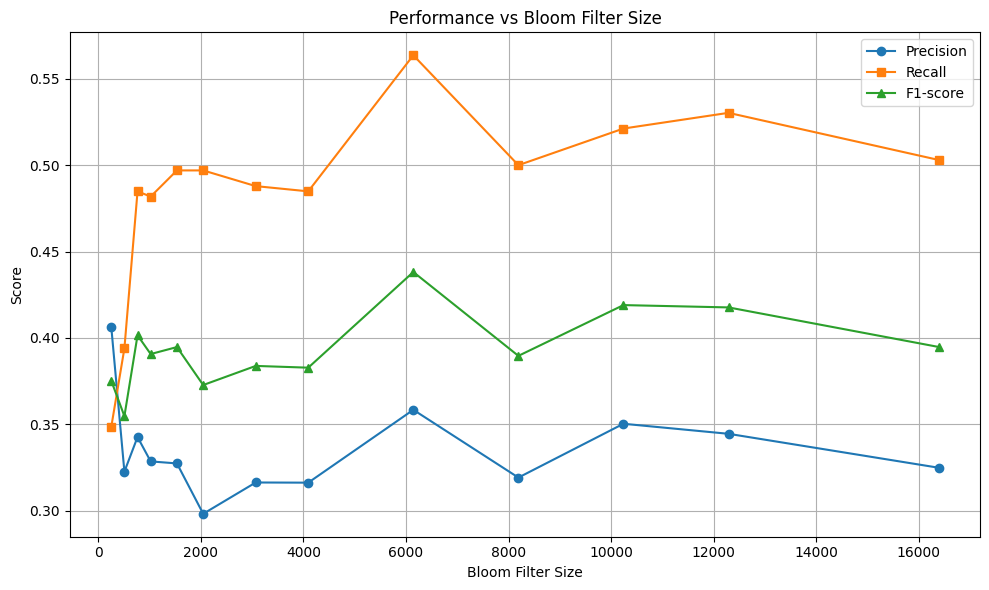

In [276]:
best_row = df_bloom.loc[df_bloom['F1'].idxmax()]
best_bloom_size = int(best_row['Bloom Size'])
print(f"✅ Best Bloom Filter Size: {int(best_row['Bloom Size'])}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1 Score: {best_row['F1']:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(df_bloom["Bloom Size"], df_bloom["Precision"], label='Precision', marker='o')
plt.plot(df_bloom["Bloom Size"], df_bloom["Recall"], label='Recall', marker='s')
plt.plot(df_bloom["Bloom Size"], df_bloom["F1"], label='F1-score', marker='^')
plt.xlabel("Bloom Filter Size")
plt.ylabel("Score")
plt.title("Performance vs Bloom Filter Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [277]:
# Assuming best_bloom_size is already defined
hash_counts = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20]
results_hashes = []

for h in hash_counts:
    print(f"\n--- Testing num_hashes: {h} ---")
    precision, recall, f1, recon_websites, reconstructed_freq, recon_labels, true_malicious = run_pipeline(
        threshold=best_threshold,          # from df_threshold
        num_hashes=h,
        num_bloombits=best_bloom_size      # <--- Reusing saved Bloom size
    )
    
    detected = len(recon_websites)
    true_phishing = len(true_malicious)
    matched = sum(recon_labels)
    
    results_hashes.append((h, precision, recall, f1, detected, true_phishing, matched))

df_hashes = pd.DataFrame(results_hashes, columns=[
    "Num Hashes", "Precision", "Recall", "F1", "Detected", "True Phishing", "Matched"
])




--- Testing num_hashes: 1 ---
View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 544 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://43.134.167.94/servicelogin?passive=1209600&amp;continue=https://accounts.google.com/?&amp;xrealip=107.178.232.242&amp;followup=https://accounts.google.com/?&amp;xrealip=107.178.232.242	label=1
http://65695fac.wmctc.uk/?serv=rafal.szczecin.pl	label=1
http://7054company.github.io/etherumwallet	label=1
http://bafybeibkgor6o4si6frcggxpnkpmanvk77xarnbvnzv5orsjlmefg3yqhm.ipfs.dweb.link/	label=1
http://btconnect-8a0479.webflow.io/	label=1
http://burghdogs.com/landmarkcuauth	label=1
http://centrica.comrqzrofxnhwwgrqzrofrofxnhwagx2nfse2nfagx2nfsesewxnhwagxwgrqzg.mustaccio.com/0.php#ywnjb3vudhnay2vudhjpy2euy29t	label=1
http://cn52393.tw1.ru/ups/login/details.php	label=1
http://con2dapps.com	label=1
http://cpanel10wh.bkk1.cloud.z.com/~cp785288/hlep/login/billing.php

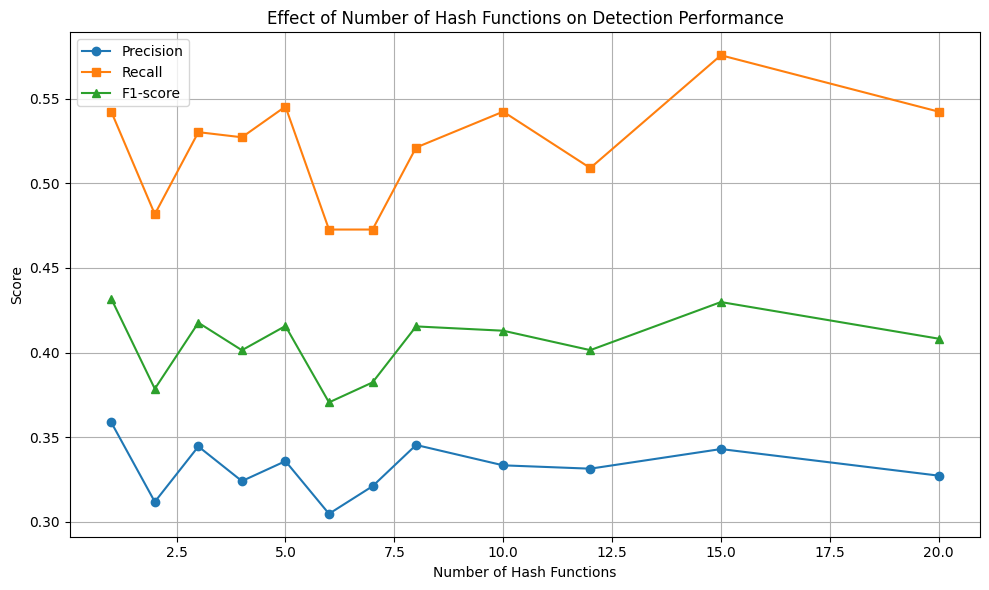

In [278]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_hashes["Num Hashes"], df_hashes["Precision"], label='Precision', marker='o')
plt.plot(df_hashes["Num Hashes"], df_hashes["Recall"], label='Recall', marker='s')
plt.plot(df_hashes["Num Hashes"], df_hashes["F1"], label='F1-score', marker='^')
plt.xlabel("Number of Hash Functions")
plt.ylabel("Score")
plt.title("Effect of Number of Hash Functions on Detection Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [279]:
best_row = df_hashes.loc[df_hashes['F1'].idxmax()]
best_hash= int(best_row['Num Hashes'])
print(f"\n✅ Best num_hashes: {int(best_row['Num Hashes'])}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1 Score: {best_row['F1']:.4f}")
print(f"Detected: {best_row['Detected']}")
print(f"True Phishing: {best_row['True Phishing']}")
print(f"Matched: {best_row['Matched']}")



✅ Best num_hashes: 1
Precision: 0.3587
Recall: 0.5424
F1 Score: 0.4318
Detected: 499.0
True Phishing: 330.0
Matched: 179.0


In [280]:
q_values = np.linspace(0.5, 0.95, 10)

results_q = []

for q in q_values:
    print(f"Testing prob_q = {q:.2f}")
    precision, recall, f1, *_ = run_pipeline(
        prob_q=q,
        prob_f=0.5,              # fixed
        prob_p=0.5,              # fixed
        num_bloombits=best_bloom_size ,
        num_hashes=best_hash,
        num_views=15,
        max_url_length=100,
        lambda_lasso=0.0001,
        threshold=best_threshold  # make sure this is already defined
    )
    results_q.append((q, precision, recall, f1))



Testing prob_q = 0.50
View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 519 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://65695fac.wmctc.uk/?serv=rafal.szczecin.pl	label=1
http://app-parallel-fi.netlify.app	label=1
http://bafybeibkgor6o4si6frcggxpnkpmanvk77xarnbvnzv5orsjlmefg3yqhm.ipfs.dweb.link/	label=1
http://bfi-wien.bfiwien-login.com/	label=1
http://bitly.ws/znyb	label=1
http://btconnect-8a0479.webflow.io/	label=1
http://burghdogs.com/landmarkcuauth	label=1
http://chieuphan-bdshotram.com/webs/	label=1
http://dorainsurance.com/auth.php?md=rougtfxanjhlhnskbpqm&rougtfxanjhlhnskbpqm	label=1
http://feito-para-voce-ltau.com	label=1
http://forcedie17.temp.swtest.ru/postounatou/postounatou/post/login/login.php	label=1
http://fti.unmerpas.ac.id/wp-admin/user/webgenkic/investopia/index.php?email=get@get.get	label=1
http://glaze-maple-pantry.glitch.me/link.html	label=1
http://guietnopag.the

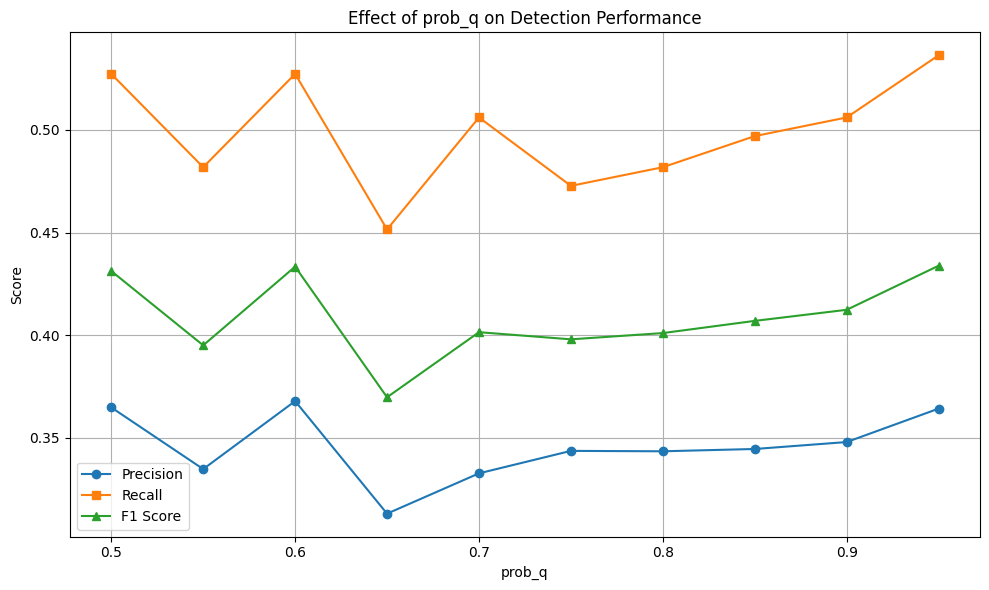


✅ Best prob_q: 0.95
Precision: 0.3642
Recall: 0.5364
F1 Score: 0.4338


In [281]:
# --- Create DataFrame ---
df_q = pd.DataFrame(results_q, columns=["prob_q", "Precision", "Recall", "F1"])

# --- Plot Metrics ---
plt.figure(figsize=(10, 6))
plt.plot(df_q["prob_q"], df_q["Precision"], label="Precision", marker='o')
plt.plot(df_q["prob_q"], df_q["Recall"], label="Recall", marker='s')
plt.plot(df_q["prob_q"], df_q["F1"], label="F1 Score", marker='^')
plt.xlabel("prob_q")
plt.ylabel("Score")
plt.title("Effect of prob_q on Detection Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Best prob_q ---
best_row = df_q.loc[df_q["F1"].idxmax()]
best_q=best_row['prob_q']
print(f"\n✅ Best prob_q: {best_row['prob_q']:.2f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1 Score: {best_row['F1']:.4f}")

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 576 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://1636365.com/assets/@popperjs.36402333.js/assets/@ctrl.fd318bfa.js/assets/@ctrl.b082b0c1.js/assets/@vueuse.7ab573ac.js/	label=1
http://198.98.58.123/	label=1
http://43.134.167.94/servicelogin?passive=1209600&amp;continue=https://accounts.google.com/?&amp;xrealip=107.178.232.242&amp;followup=https://accounts.google.com/?&amp;xrealip=107.178.232.242	label=1
http://65695fac.wmctc.uk/?serv=rafal.szczecin.pl	label=1
http://7054company.github.io/etherumwallet	label=1
http://att-103731-107123.weeblysite.com/	label=1
http://bafybeibkgor6o4si6frcggxpnkpmanvk77xarnbvnzv5orsjlmefg3yqhm.ipfs.dweb.link/	label=1
http://bitly.ws/znyb	label=1
http://burghdogs.com/landmarkcuauth	label=1
http://centrica.comrqzrofxnhwwgrqzrofrofxnhwagx2nfse2nfagx2nfsesewxnhwagxwgrqzg.mustaccio.com/0.php#ywnjb3vudhnay2vudh

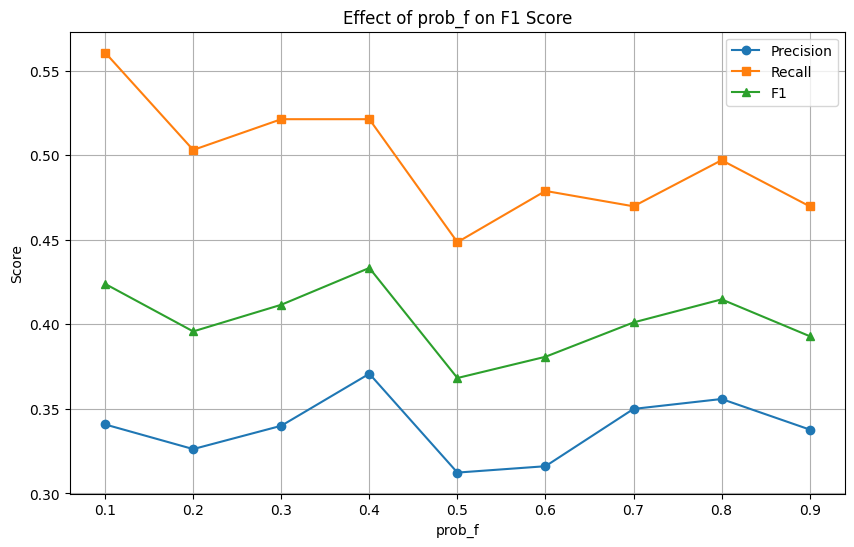


✅ Best prob_f: 0.40
Precision: 0.3707, Recall: 0.5212, F1: 0.4332


In [282]:
f_values = np.linspace(0.1, 0.9, 9)
results_f = []

for f in f_values:
    precision, recall, f1, *_ = run_pipeline(
        prob_q= best_q,  # use best from previous sweep
        prob_f=f,
        prob_p=0.5,
        num_bloombits=best_bloom_size,
        num_hashes=best_hash,
        num_views=15,
        max_url_length=100,
        lambda_lasso=0.0001,
        threshold=best_threshold
    )
    results_f.append((f, precision, recall, f1))

df_f = pd.DataFrame(results_f, columns=["prob_f", "Precision", "Recall", "F1"])
best_f = df_f.loc[df_f['F1'].idxmax()]

plt.figure(figsize=(10, 6))
plt.plot(df_f["prob_f"], df_f["Precision"], label="Precision", marker='o')
plt.plot(df_f["prob_f"], df_f["Recall"], label="Recall", marker='s')
plt.plot(df_f["prob_f"], df_f["F1"], label="F1", marker='^')
plt.title("Effect of prob_f on F1 Score")
plt.xlabel("prob_f")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()

print(f"\n✅ Best prob_f: {best_f['prob_f']:.2f}")
print(f"Precision: {best_f['Precision']:.4f}, Recall: {best_f['Recall']:.4f}, F1: {best_f['F1']:.4f}")


View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 514 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://app-parallel-fi.netlify.app	label=1
http://att-103731-107123.weeblysite.com/	label=1
http://bafybeibkgor6o4si6frcggxpnkpmanvk77xarnbvnzv5orsjlmefg3yqhm.ipfs.dweb.link/	label=1
http://bfi-wien.bfiwien-login.com/	label=1
http://btconnect-8a0479.webflow.io/	label=1
http://cn52393.tw1.ru/ups/login/details.php	label=1
http://con2dapps.com	label=1
http://cpanel10wh.bkk1.cloud.z.com/~cp785288/hlep/login/billing.php?verify_account=session=nl&amp;c9af20c816b1cce4f06368be3327e297=&amp;dispatch=15464ad822e0af50d3b1df6196cac08a9e8edfbd	label=1
http://dorainsurance.com/auth.php?md=rougtfxanjhlhnskbpqm&rougtfxanjhlhnskbpqm	label=1
http://forcedie17.temp.swtest.ru/postounatou/postounatou/post/login/login.php	label=1
http://getdrop.live	label=1
http://guietnopag.theshoeshub.club/vnafvra97w/?q=37170651

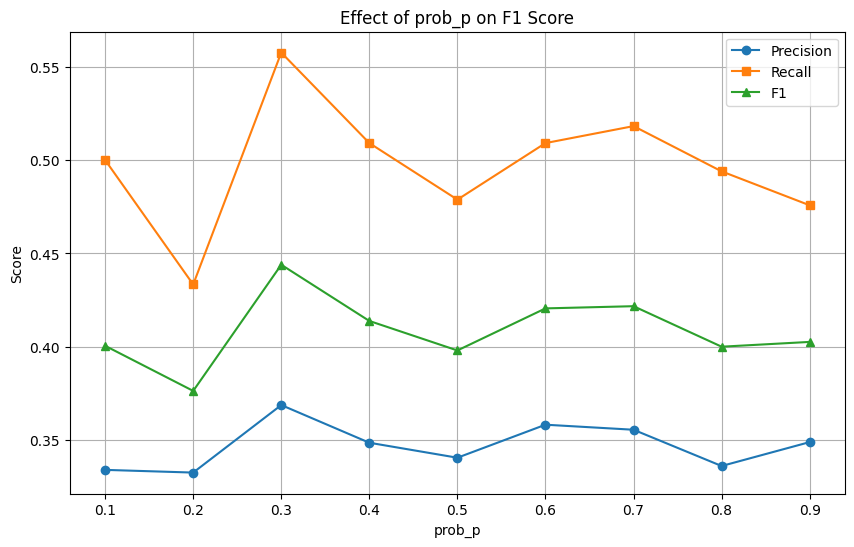


✅ Best prob_p: 0.30
Precision: 0.3687, Recall: 0.5576, F1: 0.4439


In [283]:
p_values = np.linspace(0.1, 0.9, 9)
results_p = []

for p in p_values:
    precision, recall, f1, *_ = run_pipeline(
        prob_q=best_q,
        prob_f=best_f['prob_f'],
        prob_p=p,
        num_bloombits=best_bloom_size,
        num_hashes=best_hash,
        num_views=15,
        max_url_length=100,
        lambda_lasso=0.0001,
        threshold=best_threshold
    )
    results_p.append((p, precision, recall, f1))

df_p = pd.DataFrame(results_p, columns=["prob_p", "Precision", "Recall", "F1"])
best_p = df_p.loc[df_p['F1'].idxmax()]

plt.figure(figsize=(10, 6))
plt.plot(df_p["prob_p"], df_p["Precision"], label="Precision", marker='o')
plt.plot(df_p["prob_p"], df_p["Recall"], label="Recall", marker='s')
plt.plot(df_p["prob_p"], df_p["F1"], label="F1", marker='^')
plt.title("Effect of prob_p on F1 Score")
plt.xlabel("prob_p")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.show()

print(f"\n✅ Best prob_p: {best_p['prob_p']:.2f}")
print(f"Precision: {best_p['Precision']:.4f}, Recall: {best_p['Recall']:.4f}, F1: {best_p['F1']:.4f}")


Testing lambda_lasso = 1e-05
View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 558 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://1636365.com/assets/@popperjs.36402333.js/assets/@ctrl.fd318bfa.js/assets/@ctrl.b082b0c1.js/assets/@vueuse.7ab573ac.js/	label=1
http://43.134.167.94/servicelogin?passive=1209600&amp;continue=https://accounts.google.com/?&amp;xrealip=107.178.232.242&amp;followup=https://accounts.google.com/?&amp;xrealip=107.178.232.242	label=1
http://7054company.github.io/etherumwallet	label=1
http://att-103731-107123.weeblysite.com/	label=1
http://bfi-wien.bfiwien-login.com/	label=1
http://btconnect-8a0479.webflow.io/	label=1
http://burghdogs.com/landmarkcuauth	label=1
http://centrica.comrqzrofxnhwwgrqzrofrofxnhwagx2nfse2nfagx2nfsesewxnhwagxwgrqzg.mustaccio.com/0.php#ywnjb3vudhnay2vudhjpy2euy29t	label=1
http://chieuphan-bdshotram.com/webs/	label=1
http://con2dapps.com	label=

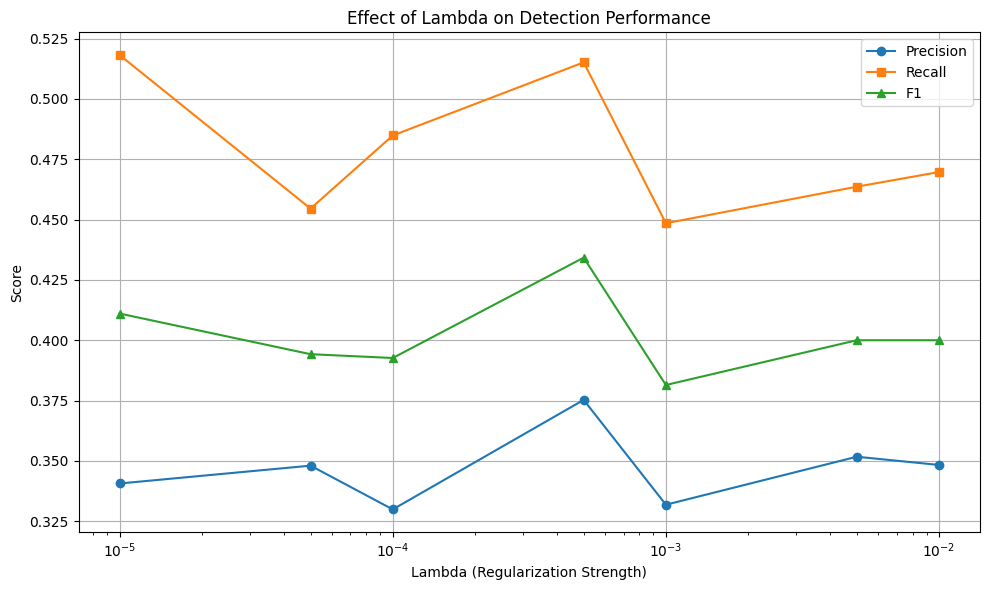


✅ Best lambda_lasso: 0.0005
Precision: 0.3753, Recall: 0.5152, F1: 0.4342


In [284]:
lambda_values = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
results_lambda = []

for lmb in lambda_values:
    print(f"Testing lambda_lasso = {lmb}")
    precision, recall, f1, *_ = run_pipeline(
        lambda_lasso=lmb,
        prob_q=best_q,         # from earlier sweep
        prob_f=best_f['prob_f'],
        prob_p=best_p['prob_p'],
        num_bloombits=best_bloom_size,
        num_hashes=best_hash,
        num_views=15,
        max_url_length=100,
        threshold=best_threshold         # previously tuned
    )
    results_lambda.append((lmb, precision, recall, f1))

df_lambda = pd.DataFrame(results_lambda, columns=["Lambda", "Precision", "Recall", "F1"])

# 📊 Plot
plt.figure(figsize=(10, 6))
plt.plot(df_lambda["Lambda"], df_lambda["Precision"], label="Precision", marker='o')
plt.plot(df_lambda["Lambda"], df_lambda["Recall"], label="Recall", marker='s')
plt.plot(df_lambda["Lambda"], df_lambda["F1"], label="F1", marker='^')
plt.xscale('log')  # Log scale for lambda
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Score")
plt.title("Effect of Lambda on Detection Performance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Best
best_lambda = df_lambda.loc[df_lambda['F1'].idxmax()]
print(f"\n✅ Best lambda_lasso: {best_lambda['Lambda']}")
print(f"Precision: {best_lambda['Precision']:.4f}, Recall: {best_lambda['Recall']:.4f}, F1: {best_lambda['F1']:.4f}")


Testing num_views = 15
View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
Used LASSO: 510 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://198.98.58.123/	label=1
http://43.134.167.94/servicelogin?passive=1209600&amp;continue=https://accounts.google.com/?&amp;xrealip=107.178.232.242&amp;followup=https://accounts.google.com/?&amp;xrealip=107.178.232.242	label=1
http://65695fac.wmctc.uk/?serv=rafal.szczecin.pl	label=1
http://7054company.github.io/etherumwallet	label=1
http://app-parallel-fi.netlify.app	label=1
http://bafybeibkgor6o4si6frcggxpnkpmanvk77xarnbvnzv5orsjlmefg3yqhm.ipfs.dweb.link/	label=1
http://bfi-wien.bfiwien-login.com/	label=1
http://bitly.ws/znyb	label=1
http://btconnect-8a0479.webflow.io/	label=1
http://centrica.comrqzrofxnhwwgrqzrofrofxnhwagx2nfse2nfagx2nfsesewxnhwagxwgrqzg.mustaccio.com/0.php#ywnjb3vudhnay2vudhjpy2euy29t	label=1
http://cn52393.tw1.ru/ups/login/details.php	label=1
htt

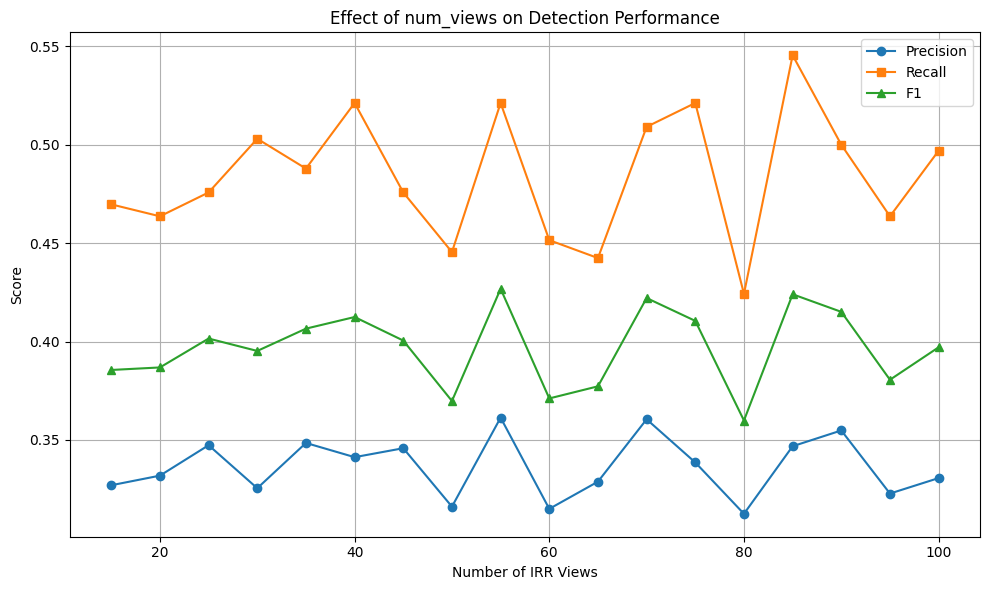


✅ Best num_views: 55
Precision: 0.3613
Recall: 0.5212
F1 Score: 0.4268


In [285]:
view_counts = list(range(15, 101, 5))  # 15, 20, 25, ..., 100
results_views = []

for v in view_counts:
    print(f"Testing num_views = {v}")
    precision, recall, f1, *_ = run_pipeline(
        num_views=v,
        lambda_lasso=best_lambda['Lambda'],   # use your best lambda
        prob_q=best_q,
        prob_f=best_f['prob_f'],
        prob_p=best_p['prob_p'],
        num_bloombits=best_bloom_size,
        num_hashes=best_hash,
        max_url_length=100,
        threshold=best_threshold               # best threshold so far
    )
    results_views.append((v, precision, recall, f1))

# DataFrame to store results
df_views = pd.DataFrame(results_views, columns=["Num Views", "Precision", "Recall", "F1"])

# 📊 Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_views["Num Views"], df_views["Precision"], label="Precision", marker='o')
plt.plot(df_views["Num Views"], df_views["Recall"], label="Recall", marker='s')
plt.plot(df_views["Num Views"], df_views["F1"], label="F1", marker='^')
plt.xlabel("Number of IRR Views")
plt.ylabel("Score")
plt.title("Effect of num_views on Detection Performance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Best view count
best_views = df_views.loc[df_views['F1'].idxmax()]
print(f"\n✅ Best num_views: {int(best_views['Num Views'])}")
print(f"Precision: {best_views['Precision']:.4f}")
print(f"Recall: {best_views['Recall']:.4f}")
print(f"F1 Score: {best_views['F1']:.4f}")


In [288]:
with open("best_hyperparams_summary.txt", "w") as f:
    f.write("Best Hyperparameters:\n")
    f.write(f"Threshold: {best_threshold:.6f}\n")
    f.write(f"Bloom Size: {best_bloom_size}\n")
    f.write(f"Num Hashes: {best_hash}\n")
    f.write(f"Num Views: {int(best_views['Num Views'])}\n")
    f.write(f"lambda_lasso: {best_lambda['Lambda']:.1e}\n")
    f.write(f"prob_p: {best_p['prob_p']}\n")
    f.write(f"prob_q: {best_q}\n")
    f.write(f"prob_f: {best_f['prob_f']}\n\n")
    f.write("Performance:\n")
    f.write(f"Precision: {best_views['Precision']:.4f}\n")
    f.write(f"Recall: {best_views['Recall']:.4f}\n")
    f.write(f"F1 Score: {best_views['F1']:.4f}\n")


Testing threshold = 0.00000000
View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8
View 9
View 10
View 11
View 12
View 13
View 14
View 15
View 16
View 17
View 18
View 19
View 20
View 21
View 22
View 23
View 24
View 25
View 26
View 27
View 28
View 29
View 30
View 31
View 32
View 33
View 34
View 35
View 36
View 37
View 38
View 39
View 40
View 41
View 42
View 43
View 44
View 45
View 46
View 47
View 48
View 49
View 50
View 51
View 52
View 53
View 54
View 55
Used LASSO: 478 non-zero coefficients

Reconstructed Websites (label = 1 = phishing):
http://att-103731-107123.weeblysite.com/	label=1
http://bfi-wien.bfiwien-login.com/	label=1
http://cn52393.tw1.ru/ups/login/details.php	label=1
http://con2dapps.com	label=1
http://dfjhjhjb2.com/?fds21fds54fds54sd	label=1
http://dorainsurance.com/auth.php?md=rougtfxanjhlhnskbpqm&rougtfxanjhlhnskbpqm	label=1
http://getdrop.live	label=1
http://ianacurtis.rmxcontabilidade.com.br	label=1
http://mail.jila.se///vex7/hinet.html	label=1
http://metmask-walle

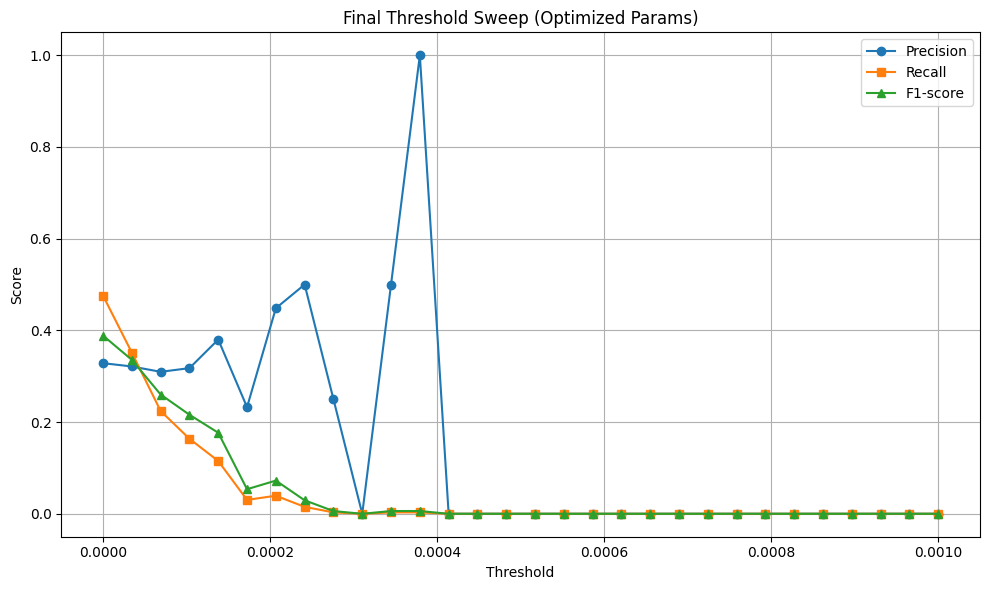


✅ Best Threshold (Final Sweep):
Threshold: 0.00000000
Precision: 0.3285
Recall: 0.4758
F1 Score: 0.3886


In [289]:
# Define a tighter threshold range (around 0)
thresholds = np.linspace(0, 0.001, 30)  # more fine-grained
results_final_threshold = []

for th in thresholds:
    print(f"Testing threshold = {th:.8f}")
    precision, recall, f1, *_ = run_pipeline(
        threshold=th,
        num_bloombits=6144,
        num_hashes=1,
        num_views=55,
        lambda_lasso=5e-4,
        prob_p=0.3,
        prob_q=0.95,
        prob_f=0.4,
        max_url_length=100
    )
    results_final_threshold.append((th, precision, recall, f1))

# Create DataFrame
df_final_thresh = pd.DataFrame(results_final_threshold, columns=["Threshold", "Precision", "Recall", "F1"])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_final_thresh["Threshold"], df_final_thresh["Precision"], label='Precision', marker='o')
plt.plot(df_final_thresh["Threshold"], df_final_thresh["Recall"], label='Recall', marker='s')
plt.plot(df_final_thresh["Threshold"], df_final_thresh["F1"], label='F1-score', marker='^')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Final Threshold Sweep (Optimized Params)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Report best threshold
best_thresh_row = df_final_thresh.loc[df_final_thresh["F1"].idxmax()]
print("\n✅ Best Threshold (Final Sweep):")
print(f"Threshold: {best_thresh_row['Threshold']:.8f}")
print(f"Precision: {best_thresh_row['Precision']:.4f}")
print(f"Recall: {best_thresh_row['Recall']:.4f}")
print(f"F1 Score: {best_thresh_row['F1']:.4f}")
